# Analisi Sottoreti - single day - aggregated days

In [1]:
from collections import defaultdict
from datetime import datetime
import json
import os
import polars as pl
import pandas as pd
import geopandas as gpd
from GeographyFunctions import FilterGeoDataFrameWithBoundingBox
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import numpy as np
from SubNetworks import *
from SubNetworksPlot import *


# Input variables

In [2]:
## ------------ SHARED VARIABLES ----------------- ##
# Important Folders
city_pro_dir = os.path.join(os.environ["WORKSPACE"],"city-pro") 
vars_dir = os.path.join(city_pro_dir, "vars")
# Config
dir_config_analysis_day = os.path.join(vars_dir,"config","config_days_bbox.json")
# N classes 
with open(os.path.join(dir_config_analysis_day),"r") as f:
    config_analysis_day = json.load(f)

# Name project-bbox
prefix_files = "bologna_mdt"
name_project_related_to_bbox = config_analysis_day["name_project"]


# Folders
config_dir = os.path.join(city_pro_dir,name_project_related_to_bbox)
fcm_dir = os.path.join(os.environ["WORKSPACE"],"city-pro","output",name_project_related_to_bbox)
PlotDir = os.path.join(fcm_dir, "plots")



# Parameters Days - Classes
StrDates = config_analysis_day["str_dates"]
num_tm = config_analysis_day["num_tm"]
labels = [str(i) for i in range(num_tm + 1)]
Classes = [int(i) for i in range(num_tm + 1)]

# Variables of Interest
Features = ["time_hours", "lenght_km"]

# 
lon_min,lon_max,lat_min,lat_max = config_analysis_day["lon_min"], config_analysis_day["lon_max"], config_analysis_day["lat_min"], config_analysis_day["lat_max"]
Bbox = (lon_min, lon_max, lat_min, lat_max)


# Variables .ipynb

In [3]:
Union_column_name = "Union"
sample_date = "2022-01-31"          # NOTE: this is a random date we need to have poly_cid in the geojson: NOT OPTIMAL
fluxs_file_path_single_date = os.path.join(fcm_dir,"weights",f"{prefix_files}_{sample_date}_{sample_date}.fluxes.sub")

lids2focus = {33280:"autostrada sole (sud) dir. sud",
              77096:"autostrada sole (sud) dir. nord",
              2708:"autostrada sole (nord) dir. sud",
              49350:"autostrada bologna padova dir. sud",
              39431:"autostrada bologna padova dir. nord",
              45240:"autostrada adriatica dir. sud",
              2603:"autostrada adriatica dir. nord",
              31386:"tangenziale sud verso casalecchio",
              31717:"tangenziale sud verso san lazzaro"}
lid2color = {33280:"red",
              77096:"blue",
              2708:"green",
              49350:"black",
              39431:"yellow",
              45240:"orange",
              2603:"purple",
              31386:"pink",
              31717:"brown"}


# Hierarchical sub_net - all days 

## Import geodataframe - cut - compute union net - generate greg format

In [4]:
GdfClassesTraffic = gpd.read_file(os.path.join(fcm_dir,"BolognaMDTClassInfo.geojson"))
gdf_single_day = gpd.read_file(os.path.join(PlotDir,sample_date,f"GeoJson_{sample_date}.geojson"))
GdfClassesTraffic = FilterGeoDataFrameWithBoundingBox(GdfClassesTraffic,Bbox)
columns = ["IntClassOrdered_"+ Day for Day in StrDates]
columns.append("geometry")
Uninon_column_names = ["Union_"+str(Class) for Class in Classes]
GdfSimplified = GdfClassesTraffic[columns]
GdfClassesTraffic = GdfClassesTraffic.loc[GdfClassesTraffic["poly_lid"] != 45240]
# NOTE: Compute the subnet union over all days
GdfSimplified = Compute_Union_Column_gdf_network_simplified_from_class_days(GdfSimplified, 
                                                                            Classes, 
                                                                            Uninon_column_names, 
                                                                            StrDates)
GdfSimplified = FilterGeoDataFrameWithBoundingBox(GdfSimplified, Bbox)

## Plot union - is the union we use in NetMob

In [ ]:
path_save_plot = os.path.join(PlotDir,"union_classes.png")
# 
Plot_road_network_colored_by_hierarchical_class_when_considered_union_over_all_days(GdfSimplified,
                                                                                    path_save_plot,
                                                                                    Classes)
# Plot hierarchical network for all days separately
Columns = [col for col in GdfSimplified.columns if "IntClass" in col]
Plot_road_network_colored_by_hierarchical_class_all_days(GdfSimplified, 
                                                        PlotDir, 
                                                        Classes, 
                                                        StrDates,
                                                        Columns)
# Dynamic Plot
m = Plot_road_network_colored_by_hierarchical_class_folium(GdfSimplified, 
                                                           Classes)



# Subnets - NetMob - save 

In [10]:
def transform_gdf_greg(GdfSimplified,gdf_single_day):
    """
    Transform the GeoDataFrame GdfSimplified to match the structure of gdf_single_day.
    """
    gdf_greg = GdfSimplified.merge(gdf_single_day, on="geometry", suffixes=('_simplified', '_single_day'))
    gdf_greg.rename(columns={"poly_cid":"id"},inplace=True)
    gdf_greg.rename(columns={"poly_nF":"sourceId"},inplace=True)
    gdf_greg.rename(columns={"poly_nT":"targetId"},inplace=True)
    gdf_greg.rename(columns={"poly_length":"length"},inplace=True)
    class2speed = {0:4,1:21,2:42,3:92}
    gdf_greg["maxSpeed"] = gdf_greg["Union"].apply(lambda x: class2speed.get(x))
    return gdf_greg
gdf_greg = transform_gdf_greg(GdfSimplified,gdf_single_day)
gdf_greg = gdf_greg[["id","sourceId","targetId","length","Union","geometry","maxSpeed","poly_lid"]]
gdf_greg.to_file(os.path.join(PlotDir,"bologna_ceenter_union.geojson"),index=False)


2025-07-28 12:29:38,252 - INFO - Created 13,129 records


# Graph analysis

In [9]:
gdf_greg.columns

Index(['IntClassOrdered_2022-12-30', 'IntClassOrdered_2022-12-31',
       'IntClassOrdered_2023-01-01', 'IntClassOrdered_2022-11-11',
       'IntClassOrdered_2022-07-01', 'IntClassOrdered_2022-08-05',
       'IntClassOrdered_2022-01-31', 'IntClassOrdered_2023-03-18', 'geometry',
       'Union_0', 'Union_1', 'Union_2', 'Union_3', 'Union', 'poly_lid', 'id',
       'length', 'sourceId', 'targetId', 'maxSpeed'],
      dtype='object')

In [ ]:
import networkx as nx
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString
from tqdm import tqdm

def gdf_to_directed_networkx(gdf, 
                             id_column_edge=None, 
                             id_column_source=None,
                             id_column_target=None):
    """
    Convert a GeoDataFrame of road segments to a directed NetworkX graph.

    Parameters:
        gdf (GeoDataFrame): must contain LineString geometries
        id_columns (list[str], optional): columns to carry as edge attributes

    Returns:
        nx.DiGraph: directed road network graph
    """
    # Control that once I have the column for the source I have it also for the target
    if id_column_source is not None:
        is_target_none_if_source_is = id_column_target is None
        if is_target_none_if_source_is:
            raise ValueError("If id_column_source is provided, id_column_target must also be provided.")
    
    G = nx.DiGraph()    
    
    for idx, row in tqdm(gdf.iterrows()):
        geom = row.geometry
        if id_column_source is not None:
            start_id = row[id_column_source]
        if id_column_target is not None:
            end_id = row[id_column_target]
        if not isinstance(geom, LineString):
            continue  # skip invalid geometries

        coords = list(geom.coords)
        start = coords[0]
        end = coords[-1]

        # Optional: round coordinates to reduce duplicates
        start = tuple(round(c, 6) for c in start)
        end = tuple(round(c, 6) for c in end)

        attrs = {
                 'geometry': geom, 
                 'length': geom.length
                }
        if id_column_source is not None:
            G.add_edge(start_id, end_id, **attrs)
            if "coords" not in G.nodes[start_id]:
                G.nodes[start_id]["coords"] = start
            if "coords" not in G.nodes[end_id]:
                G.nodes[end_id]["coords"] = end

    return G

G = gdf_to_directed_networkx(gdf_greg, 
                             id_column_edge="id",
                             id_column_source="sourceId",
                             id_column_target="targetId")




# Add In-Out degrees as cols

In [12]:
import pandas as pd
from shapely.geometry import LineString

def add_degrees_to_gdf(gdf, 
                       G, 
                       id_column_source = None, 
                       id_column_target = None
                       ):
    """
    Adds 'in_degree' and 'out_degree' columns to a GeoDataFrame
    of road segments based on a directed NetworkX graph G.

    Parameters:
        gdf (GeoDataFrame): with LineString geometries.
        G (networkx.DiGraph): directed graph with node degrees.

    Returns:
        GeoDataFrame: with added columns 'in_degree_start', 'out_degree_start',
                      'in_degree_end', 'out_degree_end'
    """
    in_degrees_start = []
    out_degrees_start = []
    in_degrees_end = []
    out_degrees_end = []

    for _, row in gdf.iterrows():
        geom = row.geometry
        if not isinstance(geom, LineString):
            # Use NaN if geometry is not valid
            in_degrees_start.append(pd.NA)
            out_degrees_start.append(pd.NA)
            in_degrees_end.append(pd.NA)
            out_degrees_end.append(pd.NA)
            continue
        

        start_id = row[id_column_source] 
        end_id = row[id_column_target]


        # Get degrees or fallback to 0 if node is not in graph
        in_degrees_start.append(G.in_degree(start_id) if start_id in G else 0)
        out_degrees_start.append(G.out_degree(start_id) if start_id in G else 0)
        in_degrees_end.append(G.in_degree(end_id) if end_id in G else 0)
        out_degrees_end.append(G.out_degree(end_id) if end_id in G else 0)

    # If id_column_source, id_column_target are 
    # provided, ensure they are in the GeoDataFrame



    # Add the degree columns to the GeoDataFrame
    gdf = gdf.copy()
    gdf['in_degree_start'] = in_degrees_start
    gdf['out_degree_start'] = out_degrees_start
    gdf['in_degree_end'] = in_degrees_end
    gdf['out_degree_end'] = out_degrees_end

    return gdf


gdf_greg = add_degrees_to_gdf(gdf_greg,
                              G,
                              id_column_source="sourceId",
                              id_column_target="targetId")



(array([ 773.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  246.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 8161.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 3745.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,  180.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,   24.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
        2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
        3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
        4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ]),
 <BarContainer object of 50 artists>)

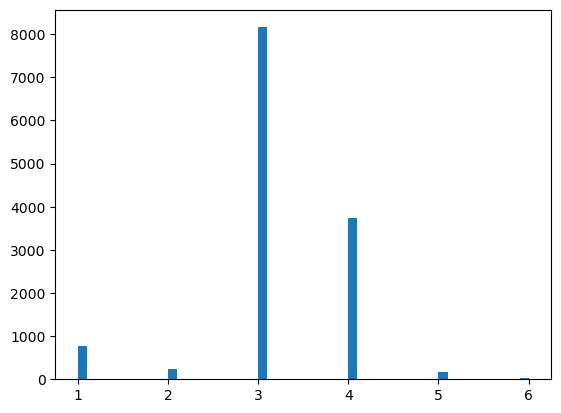

In [15]:
gdf_greg["total_degree"] = gdf_greg["in_degree_start"].to_numpy() + gdf_greg["out_degree_start"].to_numpy()
plt.hist(gdf_greg["total_degree"], bins=50)

# control the network

In [ ]:
import folium
from folium import Map, GeoJson, Popup
import branca.colormap as cm

def plot_degree_on_folium(gdf,
                          degree_column="total_degree",
                          label_columns=['in_degree_start', 'out_degree_start', "total_degree"]):
    # Ensure CRS is WGS84
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs(epsg=4326)

    # Create folium map
    center = gdf.union_all().centroid
    m = folium.Map(location=[center.y, center.x], zoom_start=13, tiles='cartodbpositron')

    # Normalize color scale
    values = gdf[degree_column].fillna(0).astype(float)
    colormap = cm.LinearColormap(['blue', 'green', 'yellow', 'red'],
                                 vmin=values.min(), vmax=values.max())
    colormap.caption = f'{degree_column} (node degree)'
    colormap.add_to(m)

    for _, row in tqdm(gdf.iterrows(), desc="Plotting road segments"):
        geom = row.geometry
        if geom is None or not geom.is_valid:
            continue

        lines = [geom] if isinstance(geom, LineString) else list(geom.geoms)

        for line in lines:
            coords = [(lat, lon) for lon, lat in line.coords]  # REVERSED for folium!

            color = colormap(row[degree_column])
            label_html = "<br>".join([f"{col}: {row.get(col, 'NA')}" for col in label_columns])
            popup = folium.Popup(label_html, max_width=300)

            folium.PolyLine(
                coords,
                color=color,
                weight=3,
                opacity=0.8,
                popup=popup,
            ).add_to(m)

    return m
gdf_greg['in_degree_start'] = pd.to_numeric(gdf_greg['in_degree_start'], errors='coerce').fillna(0)
gdf_greg['out_degree_start'] = pd.to_numeric(gdf_greg['out_degree_start'], errors='coerce').fillna(0)

m = plot_degree_on_folium(gdf_greg, degree_column='total_degree', label_columns=['in_degree_start', 'out_degree_start','total_degree'])
m.save(os.path.join(PlotDir, "degree_plot.html"))

Plotting road segments: 13129it [00:02, 6550.38it/s]


# sub_net - fuzzy

In [ ]:
# Read the road classification data and create lists for each class

# Dictionary to store road IDs for each class
class_road_lists = {}

try:
    with open(fluxs_file_path_single_date, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        line = line.strip()
        if line and not line.startswith("//"):  # Skip empty lines and comments
            parts = line.split("\t")
            if len(parts) >= 2:
                class_name = parts[0]  # e.g., "class_0_80", "class_1_80", etc.
                road_ids_str = parts[1:]  # The long string of road IDs
                # Convert string of road IDs to list of integers
                road_ids = [int(road_id) for road_id in road_ids_str if road_id.strip().isdigit()]
                
                class_road_lists[class_name] = road_ids
                print(f"{class_name}: {len(road_ids)} roads")
    
    # Display first 10 road IDs for each class as example
    for class_name, road_list in class_road_lists.items():
        print(f"\n{class_name} (first 10): {road_list[:10]}")
        
except FileNotFoundError:
    print(f"File not found: {file_path}")

# Extract just the numeric class indices (0, 1, 2, 3) and create clean lists
class_indices = {}
for class_name, road_list in class_road_lists.items():
    if "class_" in class_name and "_80" in class_name:
        # Extract class number (0, 1, 2, 3)
        class_num = int(class_name.split("_")[1])
        class_indices[class_num] = road_list


In [ ]:
# Read the road classification data for each class
classes = [0, 1, 2, 3]

# Define custom colors for each class
custom_colors = {
    0: "blue",
    1: "orange", 
    2: "green",
    3: "red"
}


# Dictionary to store road IDs for each class
class_road_lists = {}

try:
    with open(fluxs_file_path_single_date, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        line = line.strip()
        if line and not line.startswith("//"):  # Skip empty lines and comments
            parts = line.split("\t")
            if len(parts) >= 2:
                class_name = parts[0]  # e.g., "class_0_80", "class_1_80", etc.
                road_ids_str = parts[1:]  # The long string of road IDs
                # Convert string of road IDs to list of integers
                road_ids = [int(road_id) for road_id in road_ids_str if road_id.strip().isdigit()]
                
                class_road_lists[class_name] = road_ids
                print(f"{class_name}: {len(road_ids)} roads")
    
    # Display first 10 road IDs for each class as example
    for class_name, road_list in class_road_lists.items():
        print(f"\n{class_name} (first 10): {road_list[:10]}")
        
except FileNotFoundError:
    print(f"File not found: {file_path}")

# Extract just the numeric class indices (0, 1, 2, 3) and create clean lists
class_indices = {}
for class_name, road_list in class_road_lists.items():
    if "class_" in class_name and "_80" in class_name:
        # Extract class number (0, 1, 2, 3)
        class_num = int(class_name.split("_")[1])
        class_indices[class_num] = road_list
    
    # Filter GdfSimplified for roads in this class
    # Assuming 'poly_lid' is the column that matches road IDs - adjust if different
    road_id_column = 'poly_lid'  # Adjust this to match your actual column name
    
    # Create a copy of GdfSimplified for this class
    GdfClass = GdfClassesTraffic.copy()
    road_in_class = class_indices[class_num] if class_num in class_indices else []
    # Filter for roads in this class
    GdfClass = GdfClass.loc[GdfClass[road_id_column].isin(road_in_class)]
    
    if GdfClass.empty:
        print(f"No matching roads found in GeoDataFrame for class {class_}")
        continue
    
    # Ensure proper CRS
    GdfClass.to_crs(epsg=3857, inplace=True)
    
    # Create a figure for this class
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot roads for this class with class-specific color
    print(f"Plotting class {class_} with {len(GdfClass)} roads")
    GdfClass.plot(
        ax=ax, 
        color=custom_colors[class_num], 
        label=f"Class {class_num}", 
        alpha=1, 
        linewidth=2
    )
    
    # Get the bounds of the data in projected coordinates
    if not GdfClass.empty:
        minx, miny, maxx, maxy = GdfClass.total_bounds
        
        # Set limits in the projected coordinate system with some padding
        padding_x = (maxx - minx) * 0.05  # 5% padding
        padding_y = (maxy - miny) * 0.05  # 5% padding
        ax.set_xlim(minx - padding_x, maxx + padding_x)
        ax.set_ylim(miny - padding_y, maxy + padding_y)
    
    # Add a legend
    ax.legend(loc="upper right")
    
    # Remove coordinate ticks
    ax.axis('off')
    
    # Add a black and white basemap
    ctx.add_basemap(ax, crs=GdfClass.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
    
    # Add a scale bar
    fontprops = fm.FontProperties(size=12)
    scalebar = AnchoredSizeBar(ax.transData,
                               1000, '1 km', 'lower right', 
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)
    ax.add_artist(scalebar)
    
    # Add title
#    plt.title(f"Road Network - Class {class_} ({date})", fontsize=14, pad=20)
    
    # Save the figure for this class
    plt.savefig(f"/home/aamad/codice/city-pro/output/bologna_mdt_center/plots/road_class_{class_num}_{date}.png", 
                bbox_inches='tight', dpi=200)
    
    # Show the plot
    plt.show()
    
    # Close the figure to free memory
    plt.close(fig)

print("All class plots completed!")